In [40]:
import warnings
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.model_selection import train_test_split
from math import ceil

In [41]:
img_path = "/kaggle/input/fercomplilation/"
data = pd.read_csv(img_path + 'fer2013.csv')
labels = pd.read_csv(img_path+ 'fer2013new.csv')
FERnew_classes = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt','unknown','NF']
FER_classes = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear']

samples = len(data)
width = 48
height = 48

# Initialize x and y values
y = np.array(labels[FERnew_classes])
x = np.zeros((samples, width, height, 1))

for i in range(samples):
    x[i] = np.fromstring(data['pixels'][i], dtype=int, sep=' ').reshape((width, height, 1))

print(len(x))
print(len(y))

35887
35887


In [42]:
# Remove unknown and Not a Face (NF) and contempt images from both data(x) and labels(y)
indices_to_remove = []
for i in range(0,len(y)):
    max_label = np.argmax(y[i],axis = 0)
    if max_label in [7,8,9] :
        indices_to_remove.append(i)
x = np.delete(x,indices_to_remove,axis = 0)
y = np.delete(y,indices_to_remove,axis = 0)
y = y[:, :-3]
print(len(indices_to_remove))
print(len(x))
print(len(y))

615
35272
35272


In [43]:
# Label all images to particular emotions based on votes in fer2013new.csv 
label = []
for i in range(0,len(y)):
    max_label_index = np.argmax(y[i]) 
    label.append(max_label_index)
y = np.array(label)

# Conversion to binary class matrix
y = to_categorical(y)

# Normalize images
x = x / 255.0

In [44]:
# Get split size
test_size = ceil(len(x) * 0.1)
print(len(x))
print(test_size)
# 3549

# Split Data
x_train, x_test, y_train, y_test =train_test_split(x, y, test_size=test_size, random_state=42)
x_train, x_val, y_train, y_val =train_test_split(x_train, y_train, test_size=test_size,random_state=42)

35272
3528


In [45]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    height_shift_range=0.1,
    width_shift_range=0.1
)
datagen.fit(x_train)

In [58]:
img_shape = (48,48,1)
classes= len(FER_classes)

model = Sequential()

# Block 1
model.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=img_shape))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 2
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 3
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 4
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 5
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Classification block
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dense(4096, activation='relu'))
model.add(Dense(classes, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_112 (Conv2D)             │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_113 (Conv2D)             │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_114 (Conv2D)             │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_115 (Conv2D)             │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_116 (Conv2D)             │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_117 (Conv2D)             │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_118 (Conv2D)             │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_119 (Conv2D)             │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_120 (Conv2D)             │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_121 (Conv2D)             │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_122 (Conv2D)             │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_123 (Conv2D)             │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_124 (Conv2D)             │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_125 (Conv2D)             │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_126 (Conv2D)             │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_127 (Conv2D)             │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 4096)           │     2,101,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 7)              │        28,67

 Total params: 38,934,471 (148.52 MB)

 Trainable params: 38,934,471 (148.52 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
batch_size = 64
history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                    epochs=100,
                    steps_per_epoch=len(x_train) // batch_size,
                    validation_data=(x_val, y_val),
                    verbose=2)

Epoch 1/100


W0000 00:00:1717697564.485300     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717697593.149555     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


440/440 - 45s - 103ms/step - accuracy: 0.3597 - loss: 1.6056 - val_accuracy: 0.3591 - val_loss: 1.5800
Epoch 2/100
440/440 - 2s - 4ms/step - accuracy: 0.3281 - loss: 1.5259 - val_accuracy: 0.3591 - val_loss: 1.5798
Epoch 3/100
440/440 - 34s - 78ms/step - accuracy: 0.3680 - loss: 1.5633 - val_accuracy: 0.3651 - val_loss: 1.5357
Epoch 4/100
440/440 - 2s - 4ms/step - accuracy: 0.3125 - loss: 1.5963 - val_accuracy: 0.3682 - val_loss: 1.5308
Epoch 5/100
440/440 - 34s - 78ms/step - accuracy: 0.4133 - loss: 1.4828 - val_accuracy: 0.4623 - val_loss: 1.4181
Epoch 6/100
440/440 - 2s - 4ms/step - accuracy: 0.5312 - loss: 1.3300 - val_accuracy: 0.4640 - val_loss: 1.4150
Epoch 7/100
440/440 - 34s - 78ms/step - accuracy: 0.4993 - loss: 1.3745 - val_accuracy: 0.5958 - val_loss: 1.1917
Epoch 8/100
440/440 - 2s - 4ms/step - accuracy: 0.5781 - loss: 1.2540 - val_accuracy: 0.5941 - val_loss: 1.1978
Epoch 9/100
440/440 - 34s - 78ms/step - accuracy: 0.5858 - loss: 1.1981 - val_accuracy: 0.6392 - val_loss: 

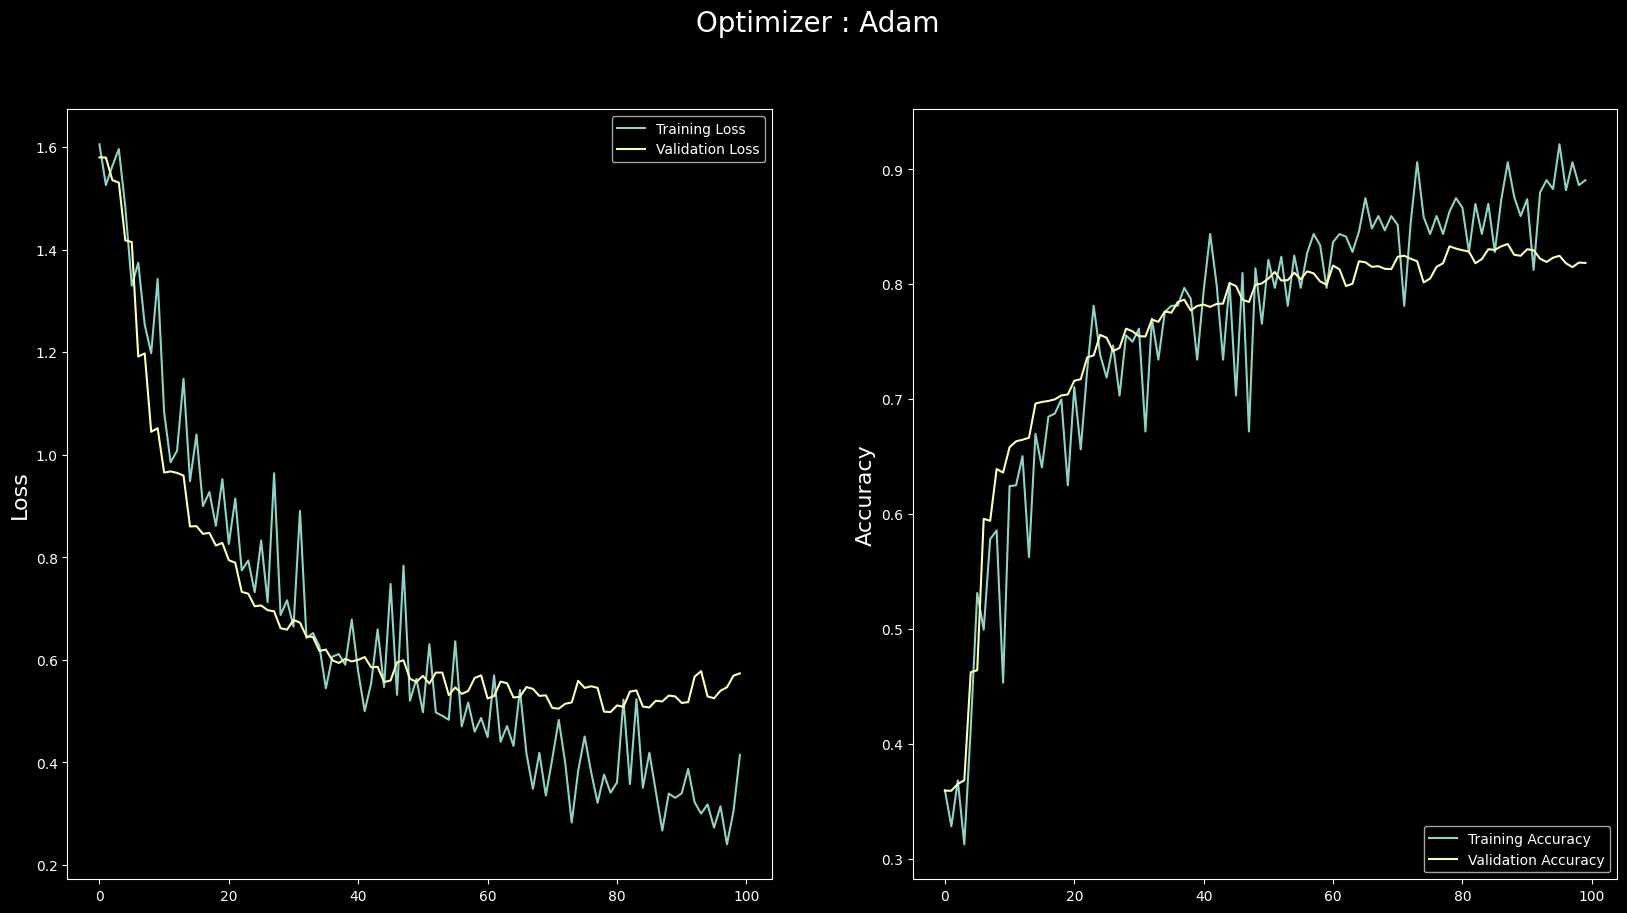

In [60]:
# Plot training & validation accuracy and loss VS epochs 
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=20)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [63]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=2)

111/111 - 3s - 28ms/step - accuracy: 0.8209 - loss: 0.5755


In [57]:
model.save(f"emosense_model_{int(accuracy*100)}.h5")

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


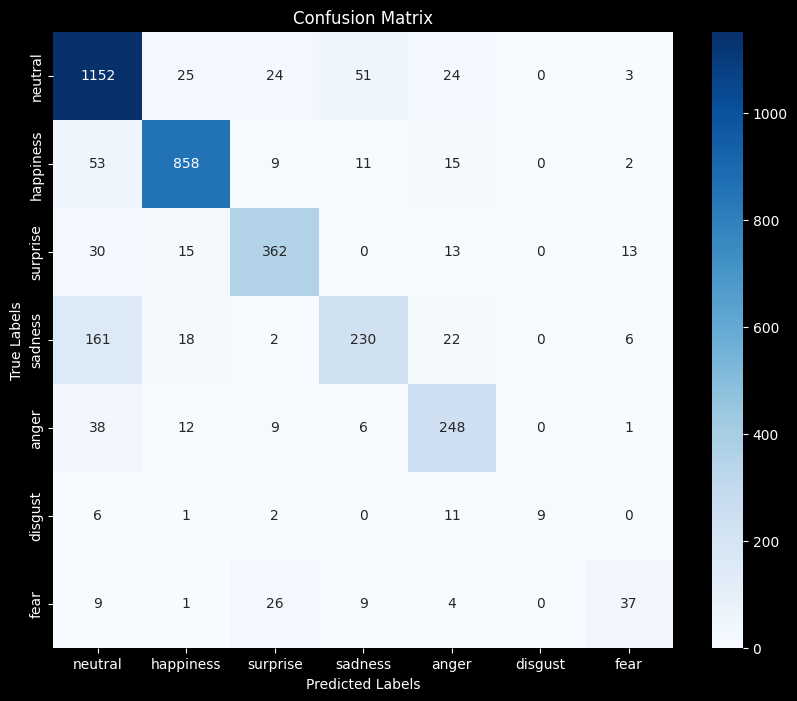

In [65]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=FER_classes, yticklabels=FER_classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()